# FRONTOGENESIS NOTEBOOK
Are there differences in frontogenesis?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.8.216.13:8787/status,
Dashboard: http://128.8.216.13:8787/status,Workers: 1
Total threads: 128,Total memory: 503.40 GiB
Status: running,Using processes: False
Comm: inproc://128.8.216.13/34473/1,Workers: 1
Dashboard: http://128.8.216.13:8787/status,Total threads: 128
Started: Just now,Total memory: 503.40 GiB
Comm: inproc://128.8.216.13/34473/4,Total threads: 128
Dashboard: http://128.8.216.13:40617/status,Memory: 503.40 GiB
Nanny: None,


In [3]:
def loadPV(filename, chunks='auto', avg=False):
    # note here that filename should be the directory of history files
    from glob import glob

    
    if avg:
        files = sorted(glob(filename+'jet_avg.*.nc'))
    else:
        files = sorted(glob(filename+'jet_pv*.nc'))
    dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)

    dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1) ### IS THIS CORRECT???? NEED TO VERIFY!!
    dsWC['rho'] = dsWC.temp
    dsWC = dsWC.swap_dims({'time':'ocean_time'})
    dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=1, s_rho=-1).mean()) + 1)/2e-4 + 20
    return dsWC, grid

In [ ]:
chunks={'time':1, 's_rho':5, 's_w':5}

runname = 'JET_NML_CFB_BFLUX'
dsWC_PV = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)


runname = 'JET_NML_NOCFB_BFLUX'
dsNC_PV = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
dsNC_PV


In [5]:
## LOAD THE NEW RUNS
reload(lruns)
chunks = {'time':1}
runname = 'JET_NML_CFB_BFLUX'
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/'+runname +'/', chunks=chunks)

#dsWC['f'] = dsOLD.f

reload(lruns)
runname = 'JET_NML_NOCFB_BFLUX'
# dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
dsNC, gridNC = lruns.newLoad('../data/model/'+runname +'/', chunks=chunks)


In [6]:
dsWC = dsWC.sel(ocean_time=slice(dsNC.ocean_time[0], dsNC.ocean_time[-1]))
dsWC

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001,
                 s_rho: 100, s_w: 101, ocean_time: 46, auxil: 4)
Coordinates: (12/26)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(100, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(100, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/68)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_v        (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(1, 101, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(1, 101, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
Attributes: (12/55)
    type:          ROMS history file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

## Define FRONTOGENESIS TERMS

In [7]:
def frontofunc(u_x, v_x, u_y, v_y):
#i = x
    # j=x 
        # k=x
    xxx = u_x**3
        # k=y
    xxy = u_x*v_x*u_y
    # j=y
        # k=x
    xyx = v_x*u_x*v_x
        # k=y
    xyy = v_x*v_x*v_y
#i = y
    # j=x
        # k=x
    yxx = u_y*u_y*u_x
        # k=y
    yxy = u_y*v_y*u_y
    # j=y
        # k=x
    yyx = v_y*u_y*v_x
        # k=y
    yyy = v_y**3
    adv= xxx + xxy + xyx + xyy + yxx + yxy + yyx + yyy
    adv = - adv # sign for positive rate of change
    return adv

In [8]:
# define frontogenesis terms
# Following McWilliams 2020 equatino 5
v_x = xroms.to_rho(gridWC.derivative(dsWC.v, 'X'), gridWC)
u_y = xroms.to_rho(gridWC.derivative(dsWC.u, 'Y'), gridWC)
v_y = xroms.to_rho(gridWC.derivative(dsWC.v, 'Y', boundary='extend'), gridWC)
u_x = xroms.to_rho(gridWC.derivative(dsWC.u, 'X', boundary='extend'), gridWC)
b_x = xroms.to_rho(gridWC.derivative(dsWC.rho, 'X'), gridWC)
b_y = xroms.to_rho(gridWC.derivative(dsWC.rho, 'Y'), gridWC)

adv_WC = frontofunc(u_x, v_x, u_y, v_y)
bb_WC = -(u_x*b_x**2 + v_y*b_y**2) + b_x*b_y*(u_y+v_x)

Tu_WC = adv_WC/(np.abs(u_x+u_y+v_x+v_y)**2)
adv_WC

# define frontogenesis terms
# Following McWilliams 2020 equatino 5
v_xnc = xroms.to_rho(gridNC.derivative(dsNC.v, 'X'), gridNC)
u_ync = xroms.to_rho(gridNC.derivative(dsNC.u, 'Y'), gridNC)
v_ync = xroms.to_rho(gridNC.derivative(dsNC.v, 'Y', boundary='extend'), gridNC)
u_xnc = xroms.to_rho(gridNC.derivative(dsNC.u, 'X', boundary='extend'), gridNC)
b_xnc = xroms.to_rho(gridNC.derivative(dsNC.rho, 'X'), gridNC)
b_ync = xroms.to_rho(gridNC.derivative(dsNC.rho, 'Y'), gridNC)

adv_NC = frontofunc(u_xnc, v_xnc, u_ync, v_ync)
bb_NC = -(u_xnc*b_xnc**2 + v_ync*b_ync**2) + b_xnc*b_ync*(u_ync+v_xnc)

Tu_NC = adv_NC/(np.abs(u_xnc+u_ync+v_xnc+v_ync)**2)

adv_NC



<xarray.DataArray (ocean_time: 46, s_rho: 100, eta_rho: 4002, xi_rho: 1002)>
dask.array<neg, shape=(46, 100, 4002, 1002), dtype=float32, chunksize=(1, 100, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * s_rho    (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
Dimensions without coordinates: ocean_time

In [9]:
# Calculate the EBF
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
#dsWC['JF'] = (bx*xroms.to_rho(dsWC.svstr, grid) - by*xroms.to_rho(dsWC.sustr, grid))/(dsWC.f*1020*(dsWC.hbl+1))
dsWC['EBF'] = (bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)
dsWC['strain'] = np.sqrt((u_x.isel(s_rho=-1)-v_y.isel(s_rho=-1))**2 + (v_x.isel(s_rho=-1) + u_y.isel(s_rho=-1))**2)
dsWC['div'] = u_x + v_y



dsWC['smag'] = (xroms.to_rho(dsWC.sustr, gridWC)**2 + xroms.to_rho(dsWC.svstr, gridWC)**2)**(1/2)
bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by
#dsNC['JF'] = (bx*xroms.to_rho(dsNC.svstr, grid) - by*xroms.to_rho(dsNC.sustr, grid))/(dsNC.f*1020*(dsNC.hbl+1))
dsNC['EBF'] = (bx*xroms.to_rho(dsNC.svstr, gridNC) - by*xroms.to_rho(dsNC.sustr, gridNC))/(dsNC.f*1020)
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)
dsNC['smag'] = (xroms.to_rho(dsNC.sustr, gridNC)**2 + xroms.to_rho(dsNC.svstr, gridNC)**2)**(1/2)
dsNC['strain'] = np.sqrt((u_xnc.isel(s_rho=-1)-v_ync.isel(s_rho=-1))**2 + (v_xnc.isel(s_rho=-1) + u_ync.isel(s_rho=-1))**2)
dsNC['div'] = u_xnc + v_ync


# EBF perturbation
EBF_p =  xroms.to_rho((dsWC.sustr - dsNC.sustr), gridWC)*by
EBF_p -= xroms.to_rho((dsWC.svstr - dsNC.svstr), gridWC)*bx

EBF_p_b = xroms.to_rho((dsWC.sustr - dsNC.sustr), gridWC)*by**2
EBF_p_b -= xroms.to_rho((dsWC.svstr - dsNC.svstr), gridWC)*bx**2
EBF_p_b = EBF_p_b/dsWC['Nablab']



## VELOCITY FRONTOGENESIS

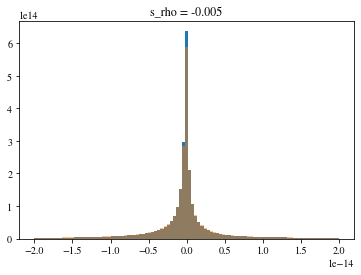

In [42]:
yl = slice(1500, 2500)
dens=True
bins = np.linspace(-2e-14, 2e-14, 100) # limits for advective function
#bins = np.linspace(-2e-4, 2e-4, 100)
tl = 5
sl = -1
adv_WC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).plot.hist(alpha=1, bins=bins, density=dens);
adv_NC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).plot.hist(alpha=0.5, bins=bins, density=dens);

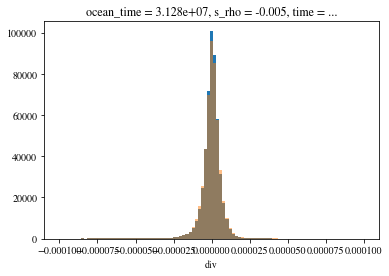

In [46]:
yl = slice(1500, 2500)
dens=True
bins = np.linspace(-1e-4, 1e-4, 100) # limits for advective function
#bins = np.linspace(-2e-4, 2e-4, 100)
tl = 2
sl = -1
dsWC.div.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).plot.hist(alpha=1, bins=bins, density=dens);
dsNC.div.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).plot.hist(alpha=0.5, bins=bins, density=dens);

In [ ]:
TUWCSEL.where(TUWCSEL**2 < 1, drop=True).plot.hist(alpha=0.5, bins=bins, density=dens);
TUNCSEL.where(TUNCSEL**2 < 1, drop=True).plot.hist(alpha=0.5, bins=bins, density=dens);

In [ ]:
tl = 3
TUWCSEL = Tu_WC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl)
TUNCSEL = Tu_NC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl)
print(f'Mean TuWC: {TUWCSEL.where(TUWCSEL**2 < 1, drop=True).mean().values}')
print(f'Mean TuNC: {TUNCSEL.where(TUNCSEL**2 < 1, drop=True).mean().values}')
print(f'Mean WC: {adv_WC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).mean().values}')
print(f'Mean NC: {adv_NC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).mean().values}')



/tmp/ipykernel_107785/623163417.py:11: UserWarning: No contour levels were found within the data range.
  plt.contour(EBF_p.isel(ocean_time=tl, eta_rho=el, xi_rho=xl), levels=[-5e-8,   5e-8], colors='black')


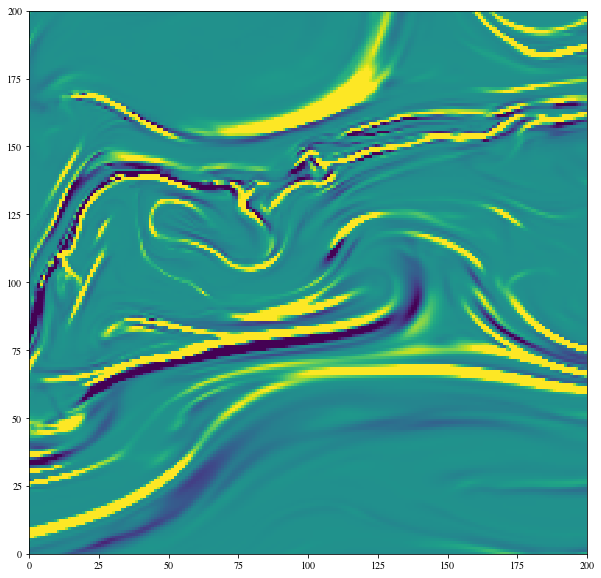

In [16]:
el = slice(1800, 2000)
xl = slice(400, 600)
tl = 10
plt.rcParams['contour.negative_linestyle'] = 'dashed'

plt.figure(figsize=(10,10))
#plt.pcolor((adv_WC - adv_NC).isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1),vmin=-1e-13, vmax=1e-13)
plt.pcolor((adv_WC ).isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1),vmin=-1e-13, vmax=1e-13)
#plt.colorbar()
#plt.contour((dsWC.EBF - dsNC.EBF).isel(ocean_time=tl, eta_rho=el, xi_rho=xl), levels=[-5e-8,   5e-8], colors='black')
plt.contour(EBF_p.isel(ocean_time=tl, eta_rho=el, xi_rho=xl), levels=[-5e-8,   5e-8], colors='black')

In [2]:
tau_p = (xroms.to_rho((dsWC.sustr - dsNC.sustr), gridWC)**2 + xroms.to_rho((dsWC.svstr - dsNC.svstr), gridWC)**2)**(1/2)
 
tau_p.isel(ocean_time=tl,eta_rho=el, xi_rho=xl).plot()

NameError: name 'xroms' is not defined

## Buoyancy fronotogenesis

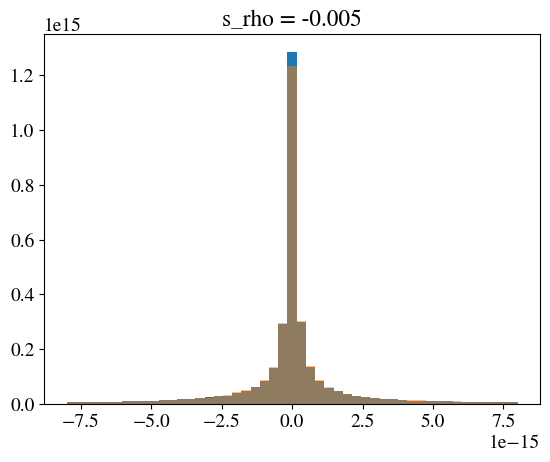

In [12]:
yl = slice(1750, 2250)
dens=True
bins = np.linspace(-5e-14, 5e-14, 50) # limits for advective function
bins = np.linspace(-8e-15, 8e-15, 50)
tl = 5
sl = -1
bb_WC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).plot.hist(alpha=1, bins=bins, density=dens);
bb_NC.isel(ocean_time=tl, eta_rho=yl, s_rho=sl).plot.hist(alpha=0.5, bins=bins, density=dens);

KeyboardInterrupt: 

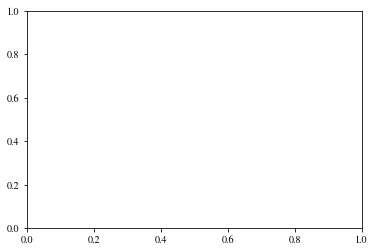

In [14]:
yl = slice(1000, 3000)
dens=True
bins = np.linspace(-5e-14, 5e-14, 100) # limits for advective function
bins = np.linspace(-5e-15, 5e-15, 100)
tl = 10
sl = -1
dsWC.strain.isel(ocean_time=tl, eta_rho=yl).plot.hist(alpha=0.5, bins=bins, density=dens);
dsNC.strain.isel(ocean_time=tl, eta_rho=yl).plot.hist(alpha=0.5, bins=bins, density=dens);

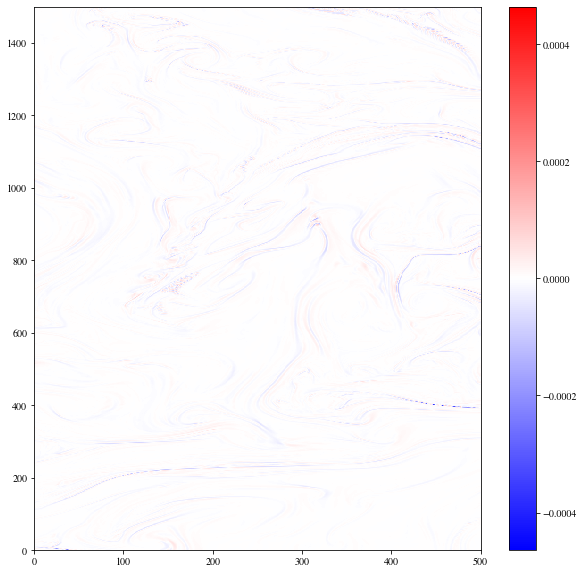

In [49]:
import matplotlib.colors as colors
el = slice(1700, 2000)
xl = slice(400, 500)
el = slice(1850, 1950)
el = slice(1500, 3000)
#xl = slice(0, 2000)
xl = slice(0,500)
#el = slice(1900, 2100)
tl = 5#5
plt.rcParams['contour.negative_linestyle'] = 'dashed'

plt.figure(figsize=(10,10))
#norm = adv_NC.isel(ocean_time=tl, eta_rho=el, xi_rho=xl, s_rho=-1).max()
#plt.pcolor(adv_WC.isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1)/norm.values,vmin=-1, vmax=1, cmap='bwr')
plt.pcolor(dsWC.div.isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1),norm = colors.CenteredNorm(), cmap='bwr')

#norm = bb_NC.isel(ocean_time=tl, eta_rho=el, xi_rho=xl, s_rho=-1).max()
#plt.pcolor(bb_WC.isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1)/norm.values,vmin=-1, vmax=1, cmap='bwr')
#plt.pcolor((bb_WC - bb_NC  ).isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1), norm = colors.CenteredNorm(), cmap='bwr')
#plt.pcolor(((bb_WC - bb_NC )/dsWC.Nablab**2).isel(s_rho=-1,ocean_time=tl, eta_rho=el, xi_rho=xl),vmin=-2, vmax=2, cmap='bwr')
#plt.pcolor((dsWC.strain.isel(ocean_time=tl, eta_rho=el, xi_rho=xl) - dsNC.strain.isel(ocean_time=tl, eta_rho=el, xi_rho=xl)), cmap='bwr')
#plt.pcolor((dsWC.EBF-dsNC.EBF).isel(ocean_time=tl, eta_rho=el, xi_rho=xl), vmin=-2e-7, vmax=2e-7, cmap='bwr')
#plt.pcolor(EBF_p_b.isel(ocean_time=tl, eta_rho=el, xi_rho=xl), vmin=-2e-7, vmax=2e-7, cmap='bwr')

plt.colorbar()
#plt.contour((dsWC.EBF-dsNC.EBF).isel(ocean_time=tl, eta_rho=el, xi_rho=xl), levels=[-5e-8,   5e-8], colors='black')
#plt.contour(EBF_p.isel(ocean_time=tl, eta_rho=el, xi_rho=xl),levels=[-1e-9, 1e-9], colors='black')
#plt.contour(((bb_WC - bb_NC )/dsWC.Nablab**2).isel(s_rho=-1,ocean_time=tl, eta_rho=el, xi_rho=xl),levels=[-1e0, 1e-0], colors='black')
#plt.contour((1 - dsNC.smag/dsWC.smag).isel(ocean_time=tl, eta_rho=el, xi_rho=xl),levels=[-1e-1, 1e-1], colors='black')
#plt.contour(dsWC.Nablab.isel(ocean_time=tl, eta_rho=el, xi_rho=xl), contours = np.logspace(-8, -5, 3))

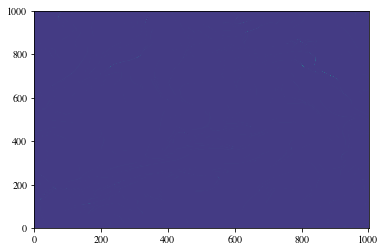

In [33]:
tl = 10
plt.pcolor(adv_WC.isel(ocean_time=tl,eta_rho=slice(1500, 2500), s_rho=-1))

In [34]:
norm.values

array(3.177833e-10, dtype=float32)

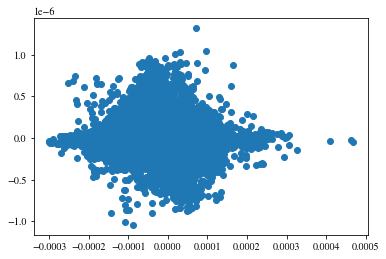

In [25]:
#plt.scatter((bb_WC - 0*bb_NC  ).isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1), (dsWC.EBF-0*dsNC.EBF).isel(ocean_time=tl, eta_rho=el, xi_rho=xl))
#plt.xlim(-1e-12, 1e-12)
plt.scatter((dsWC.strain.isel(ocean_time=tl,eta_rho=el, xi_rho=xl)- dsNC.strain.isel(ocean_time=tl,eta_rho=el, xi_rho=xl)), (dsWC.EBF-dsNC.EBF).isel(ocean_time=tl, eta_rho=el, xi_rho=xl))

In [23]:
(dsWC.strain.isel(ocean_time=tl,eta_rho=el, xi_rho=xl)- dsNC.strain.isel(ocean_time=tl,eta_rho=el, xi_rho=xl))

<xarray.DataArray 'strain' (eta_rho: 300, xi_rho: 300)>
dask.array<sub, shape=(300, 300), dtype=float32, chunksize=(300, 300), chunktype=numpy.ndarray>
Coordinates:
    ocean_time  float64 3.197e+07
  * xi_rho      (xi_rho) int64 300 301 302 303 304 305 ... 595 596 597 598 599
  * eta_rho     (eta_rho) int64 1700 1701 1702 1703 1704 ... 1996 1997 1998 1999
    x_rho       (eta_rho, xi_rho) float32 1.498e+05 1.502e+05 ... 2.992e+05
    y_rho       (eta_rho, xi_rho) float32 8.498e+05 8.498e+05 ... 9.992e+05
    time        float64 3.197e+07

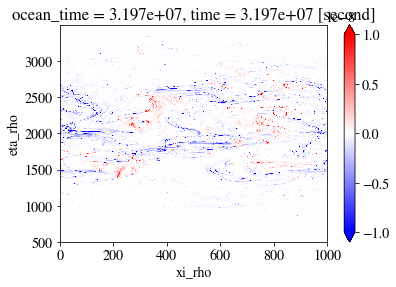

In [55]:
EBF_p_b.isel(ocean_time=10, eta_rho=slice(500, 3500)).plot(vmin = -1e-8, vmax=1e-8, cmap='bwr')

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Mean: -1.9821529140262584e-10


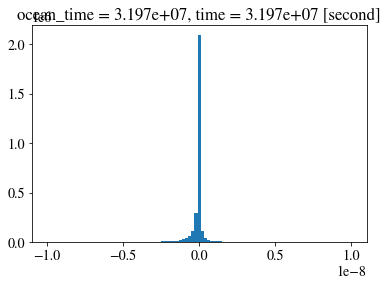

In [51]:
EBF_p_b.isel(ocean_time=10, eta_rho=slice(500, 3500)).plot.hist(bins=np.linspace(-1e-8, 1e-8, 100));
temp = EBF_p_b.isel(ocean_time=10, eta_rho=slice(500, 3500))
temp = temp.where(np.isfinite(temp), drop=True)
print(f'Mean: {temp.mean(skipna=True).values}')

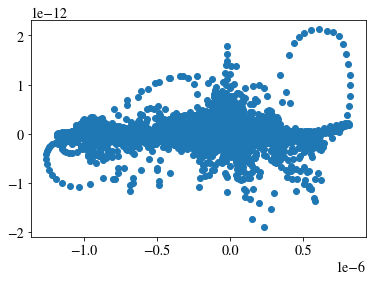

In [64]:
tl = 10

el = slice(1700, 2000)
xl = slice(400, 700)

EBF_p =  xroms.to_rho((dsWC.sustr - dsNC.sustr), gridWC)*(xroms.to_rho(gridWC.derivative(dsWC.rho, 'Y'), gridWC).isel(s_rho=-1))
EBF_p -= xroms.to_rho((dsWC.svstr - dsNC.svstr), gridWC)*(xroms.to_rho(gridWC.derivative(dsWC.rho, 'X'), gridWC).isel(s_rho=-1))

plt.scatter(EBF_p.isel(ocean_time=tl,eta_rho=el, xi_rho=xl), (bb_WC-bb_NC).isel(ocean_time=tl,eta_rho=el, xi_rho=xl, s_rho=-1))




AttributeError: 'Dataset' object has no attribute 'strain'

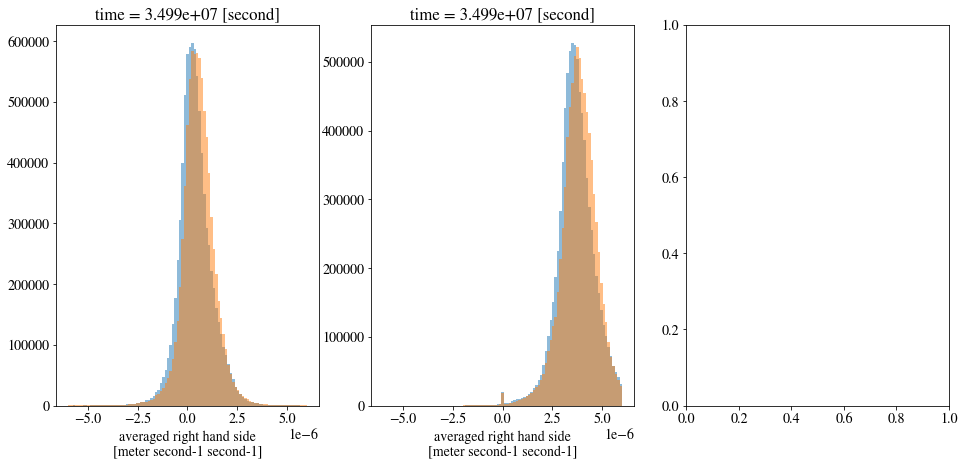

In [16]:
# Look at histograms
yl = slice(1500, 2500)
# Vorticity/Div/Strain Histogram
fig, ax = plt.subplots(1,3,figsize=(16,7), sharey=False)

sl = -15 # s_rho index to start at (goes to surface) -15 is z=100
sl = -1
tl = -1  # time index to start at (goes to end)|

dens = True # normalize
# u_rhs
bins = np.linspace(-6e-6, 6e-6, 100)
dsWC.u_rhs.isel(s_rho=sl, time=tl, eta_rho=yl).plot.hist(ax=ax[0], bins=bins, alpha=0.5, density=dens)
dsNC.u_rhs.isel(s_rho=sl, time=tl, eta_rho=yl).plot.hist(ax=ax[0], bins=bins, alpha=0.5, density=dens)
ax[0].grid()

# v_rhs
bins = np.linspace(-6e-6, 6e-6, 100)
dsWC.v_rhs.isel(s_rho=sl, time=tl, eta_v=yl).plot.hist(ax=ax[1], bins=bins, alpha=0.5, density=dens)
dsNC.v_rhs.isel(s_rho=sl, time=tl, eta_v=yl).plot.hist(ax=ax[1], bins=bins, alpha=0.5, density=dens)
ax[0].grid()

# Strain
dsWC.strain.isel(s_rho=sl, ocean_time=tl, eta_rho=yl).plot.hist(ax=ax[2], bins=bins, alpha=0.5, density=dens)
dsNC.strain.isel(s_rho=sl, ocean_time=tl, eta_rho=yl).plot.hist(ax=ax[2], bins=bins, alpha=0.5, density=dens)
ax[2].grid()

#ax[0].set_ylim(0, 2e5)

if savefig:
    plt.savefig(folder+'VortDivStrainHists.pdf', bbox_inches='tight')

In [16]:
dsWC_PV

<xarray.Dataset>
Dimensions:     (time: 45, auxil: 4, s_rho: 100, eta_rho: 4002, xi_rho: 1002, xi_u: 1001, eta_v: 4001)
Coordinates:
  * time        (time) float64 3.119e+07 3.128e+07 ... 3.491e+07 3.499e+07
Dimensions without coordinates: auxil, s_rho, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    time_step   (time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    temp_rhs    (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 5, 4002, 1002), meta=np.ndarray>
    u_rhs       (time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 5, 4002, 1001), meta=np.ndarray>
    v_rhs       (time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 5, 4001, 1002), meta=np.ndarray>
Attributes: (12/54)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    theta_s:       5.0
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [ ]:
# Perhaps the time series of domain averaged frontogenesis will differ quickly? This wouldn't however prove it is EBF that matters.
bb_WC.isel(s_rho=-1).isel(eta_rho=el, xi_rho=xl).mean(('eta_rho', 'xi_rho')).plot()

2022-12-21 15:45:51,108 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:45:55,108 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:46:00,111 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:46:04,111 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:46:08,611 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:46:12,608 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:46:17,114 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-12-21 15:46:21,111 - distributed.utils_perf - WARNING - full garbage collections took

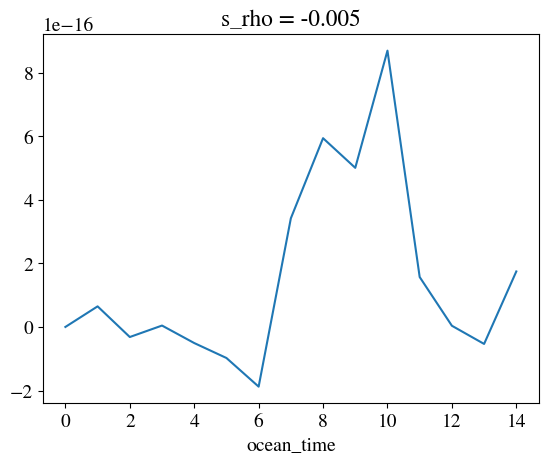

In [10]:
(bb_WC - bb_NC  ).isel(ocean_time=range(0, 30, 2), eta_rho=slice(500, 3500), s_rho=-1).mean(('eta_rho', 'xi_rho')).plot()